# Shortest Paths
(single source: from a given vertex to all vertices)

## Tools for Experiments and Drawing

We use again `networkx` for representing and drawing graphs.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from networkx.drawing.layout import circular_layout
import networkx as nx

We randomly create a directed example graph. For a better presentability, we prevent the existence of two edges (u,v) and (v,u), which is not necessary for the correctness of the algorithms.

In [2]:
import random

def create_random_weighted_digraph(no_nodes, no_edges, min_edge_weight, max_edge_weight):
    graph = nx.DiGraph()
    graph.add_nodes_from(range(no_nodes))
    all_pairs = list((x,y) for x in range(no_nodes)
                           for y in range(x + 1, no_nodes))
    # print(all_pairs)
    possible_weights = list(range(min_edge_weight, max_edge_weight + 1))
    for n1, n2 in random.sample(all_pairs, no_edges):
        weight = random.choice(possible_weights)
        v, w = random.choice(((n1, n2), (n2, n1)))
        graph.add_edge(v, w, weight=weight)
    return graph
        
graph = create_random_weighted_digraph(8, 16, 0, 30)

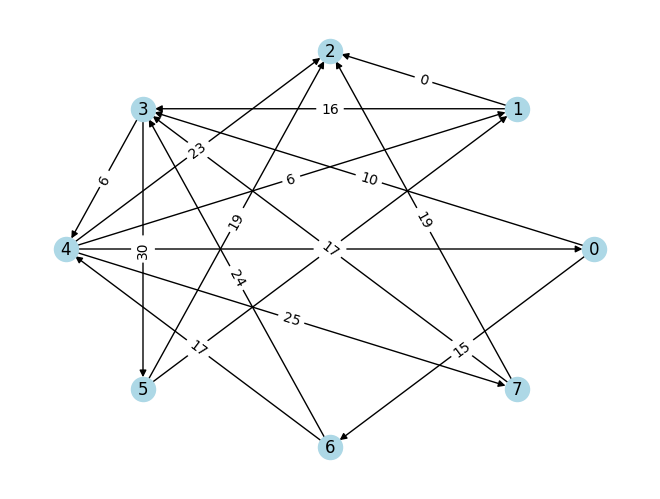

In [3]:
pos = circular_layout(graph)
edge_labels = dict([((u,v),d['weight']) for u,v,d in graph.edges(data=True)])
nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue')
_ = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

 ## Dijkstra's Algorithm

For Dijkstra's algorithm, we require a indexed priority queue. For this purpose, we copy the implementation from [Mehrgan Khoshpasand](https://mkhoshpa.github.io/IndexedPQ/) and extend it with methods `contains` and `entries`.

*The implementation details of the indexed priority queue are not a content of this course*.

In [4]:
class IndexedMinPQ:
    def __init__(self,N):
        self.N = N
        self.key = [None for i in range(self.N)]
        self.pq = [None for i in range(self.N+1)]
        self.qp =[None for i in range(self.N)]
        self.total = 0

    def insert(self,i,key):
        assert type(i) is int
        if i >= self.N:
            raise IndexError('index is out of the range of IndexedMinPQ.')
        if self.key[i] is not None:
            raise IndexError('index is already in the IndexedMinPQ.')
        self.total += 1
        self.key[i] = key
        self.pq[self.total] = i
        self.qp[i] = self.total
        self.__swim(self.total)

    def __swim(self,i):
        parent_i = i//2

        while parent_i > 0 :
            key = self.key[self.pq[i]]
            parent_key = self.key[self.pq[parent_i]]
            if parent_key < key:
                break
            self.pq[i], self.pq[parent_i] = self.pq[parent_i], self.pq[i]
            self.qp[self.pq[i]] , self.qp[self.pq[parent_i]] = self.qp[self.pq[parent_i]],self.qp[self.pq[i]]
            i = parent_i
            parent_i = i // 2

    def deleteMin(self):
        if not self.isEmpty():
            out = self.pq[1]
            self.key[self.pq[1]] = None
            self.qp[self.pq[1]] = None
            self.pq[1] = self.pq[self.total]
            self.qp[self.pq[1]] = 1
            self.pq[self.total] = None
            self.total -= 1
            self.__sink(1)
            return out
        raise IndexError('IndexedMinPQ is Empty')

    def __sink(self,i):
        child_i = i * 2
        if child_i <= self.total:
            key = self.key[self.pq[i]]
            child_key = self.key[self.pq[child_i]]
            other_child = child_i + 1
            if other_child <= self.total:
                other_child_key =  self.key[self.pq[other_child]]
                if other_child_key < child_key:
                    child_i = other_child
                    child_key = other_child_key
            if child_key < key:
                self.pq[i], self.pq[child_i] = self.pq[child_i], self.pq[i]
                self.qp[self.pq[i]], self.qp[self.pq[child_i]] = self.qp[self.pq[child_i]], self.qp[self.pq[i]]
                self.__sink(child_i)

    def isEmpty(self):
        return self.total == 0

    def decreaseKey(self,i,key):
        if i<0 or i> self.N:
            raise IndexError('index i is not in the range')
        if self.key[i] is None:
            raise IndexError('index i is not in the IndexedMinPQ')
        assert type(i) is int
        assert key < self.key[i]
        self.key[i] = key
        self.__swim(self.qp[i])

    def increaseKey(self,i,key):
        if i<0 or i> self.N:
            raise IndexError('index i is not in the range')
        if self.key[i] is None:
            raise IndexError('index i is not in the IndexedMinPQ')
        assert type(i) is int
        assert key > self.key[i]
        self.key[i] = key
        self.__sink(self.qp[i])
        
    def contains(self,i):
        return self.key[i] is not None
    
    def entries(self):
        for x in self.pq[1:]:
            if x is None:
                break
            yield x

As before, in the notebook we don't use a explicit representation of edges but the API of networkx.
We thus also do not store an array `edge_to`, but instead store the predecessor vertex on the best known path to a vertex (as previously in an array `parent`). Since we do not consider multigraphs with parallel edges, there always is just a single edge from `parent[i]` to `i`and extracting the shortest paths does not become more complicated.

In [5]:
class DijkstraSSSP:
    def __init__(self, graph, start_node, node_positions):
        self.parent = [None] * len(graph)
        self.distance = [float('inf')] * len(graph)
        pq = IndexedMinPQ(len(graph))

        self.distance[start_node] = 0
        pq.insert(start_node, 0)
        while not pq.isEmpty():
            self.relax(graph, pq.deleteMin(), pq)
            self.dump(graph, node_positions, pq)

    def relax(self, graph, v, pq):
        print("After relaxing vertex %i:" % v)
        for w in graph.successors(v):
            edge_weight = \
                graph.get_edge_data(v,w)["weight"]
            if self.distance[v] + edge_weight < \
               self.distance[w]:
                self.parent[w] = v
                self.distance[w] = self.distance[v] + edge_weight
                if pq.contains(w):
                    pq.decreaseKey(w, self.distance[w])
                else:
                    pq.insert(w, self.distance[w])

    def path_to(self, node):
        if self.distance[node] == float('inf'):
            return None
        elif self.parent[node] is None:
            return [node]
        else:
            path = self.path_to(self.parent[node])
            path.append(node)
            return path
            
    def dump(self, graph, node_positions, queue):
        print("distances:", self.distance)
        print("parents:  ", self.parent)
        reached_nodes = set(x for x in range(len(graph)) if self.distance[x] != float('inf'))
        open_nodes = set(x for x in queue.entries())
        finished_nodes = reached_nodes - open_nodes
        finished_tree = [(self.parent[i],i) for i in finished_nodes if self.parent[i] is not None]
        open_edges = [(self.parent[i],i) for i in open_nodes if self.parent[i] is not None]

        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_nodes(graph, pos, nodelist=finished_nodes, node_color='r')
        nx.draw_networkx_edges(graph, pos, edgelist=finished_tree, edge_color='r')

        nx.draw_networkx_nodes(graph, pos, nodelist=open_nodes, node_color='b')
        nx.draw_networkx_edges(graph, pos, edgelist=open_edges, edge_color='b')
        plt.show()

After relaxing vertex 0:
distances: [0, inf, inf, 10, inf, inf, 15, inf]
parents:   [None, None, None, 0, None, None, 0, None]


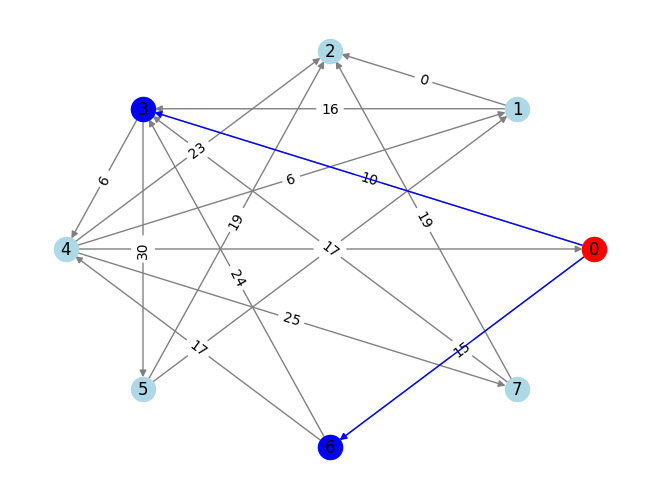

After relaxing vertex 3:
distances: [0, inf, inf, 10, 16, 40, 15, inf]
parents:   [None, None, None, 0, 3, 3, 0, None]


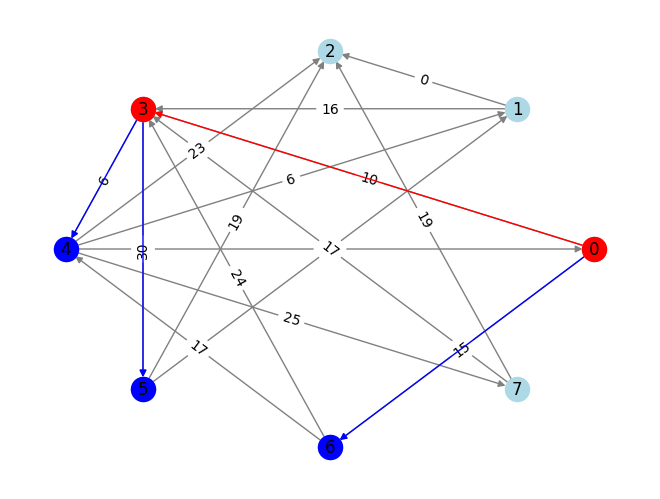

After relaxing vertex 6:
distances: [0, inf, inf, 10, 16, 40, 15, inf]
parents:   [None, None, None, 0, 3, 3, 0, None]


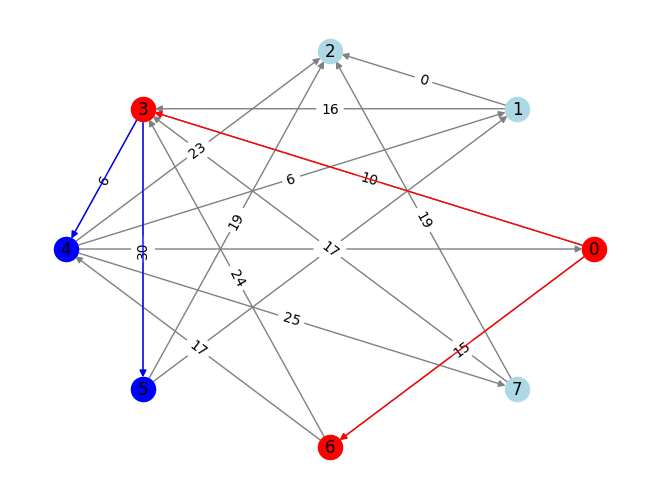

After relaxing vertex 4:
distances: [0, 22, 39, 10, 16, 40, 15, 41]
parents:   [None, 4, 4, 0, 3, 3, 0, 4]


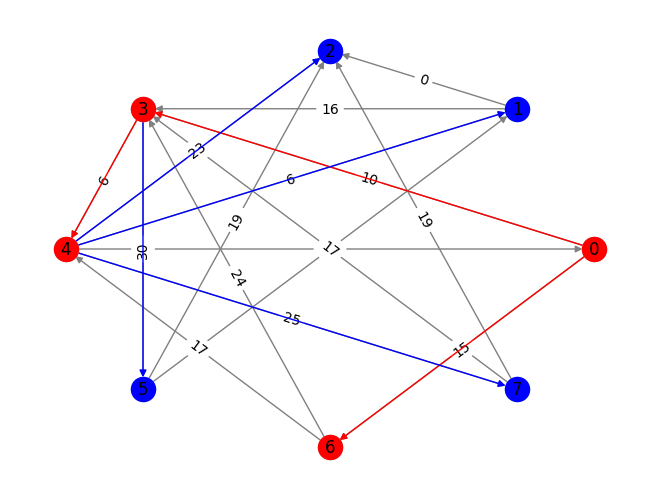

After relaxing vertex 1:
distances: [0, 22, 22, 10, 16, 40, 15, 41]
parents:   [None, 4, 1, 0, 3, 3, 0, 4]


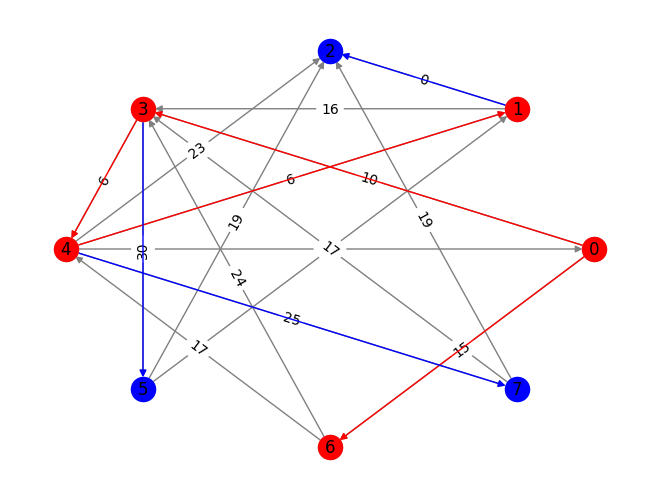

After relaxing vertex 2:
distances: [0, 22, 22, 10, 16, 40, 15, 41]
parents:   [None, 4, 1, 0, 3, 3, 0, 4]


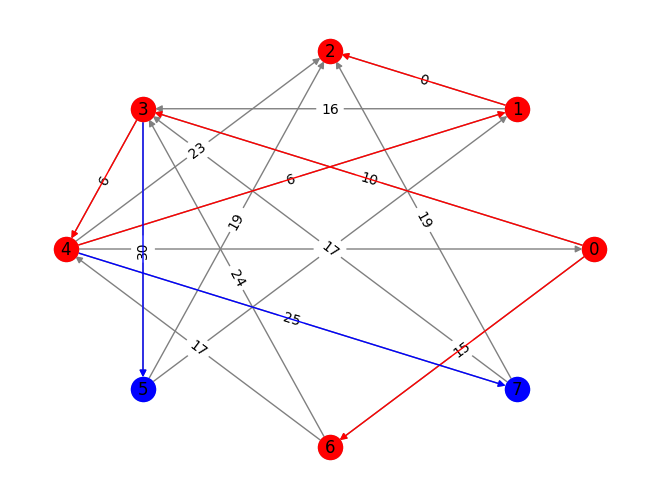

After relaxing vertex 5:
distances: [0, 22, 22, 10, 16, 40, 15, 41]
parents:   [None, 4, 1, 0, 3, 3, 0, 4]


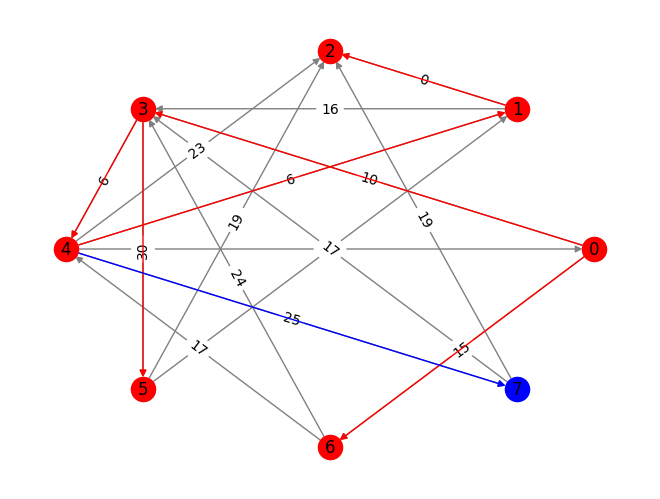

After relaxing vertex 7:
distances: [0, 22, 22, 10, 16, 40, 15, 41]
parents:   [None, 4, 1, 0, 3, 3, 0, 4]


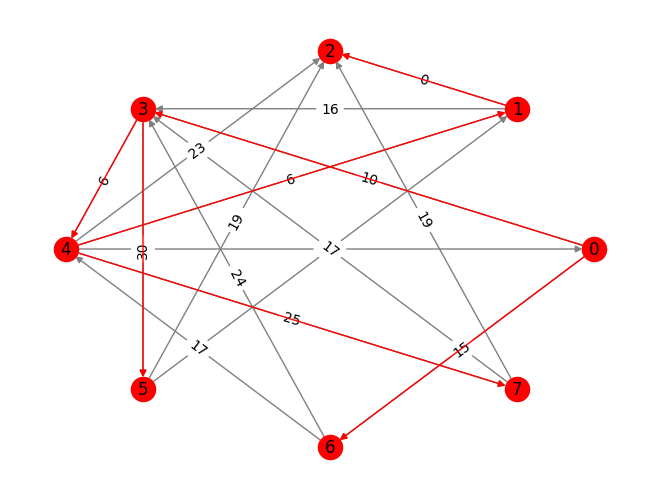

In [6]:
d = DijkstraSSSP(graph, 0, pos)

In [7]:
print(d.path_to(2))

[0, 1, 2]


 ## Acyclic Graphs

We first create a random weighted directed acyclic graph:

In [7]:
from networkx.generators.random_graphs import gnp_random_graph

def random_dag(number_nodes, min_weight, max_weight):
    random_graph = gnp_random_graph(number_nodes, 0.5, directed=True)
    # filter edges to get acyclic graph
    dag = nx.DiGraph((u,v,{'weight': random.randint(min_weight, max_weight)})
                     for u,v in random_graph.edges()
                     if u < v)
    # re-insert lost nodes
    for node in range(number_nodes):
        if node not in dag:
            dag.add_node(node)                           
    return dag
    
dag = random_dag(7, 0, 10)

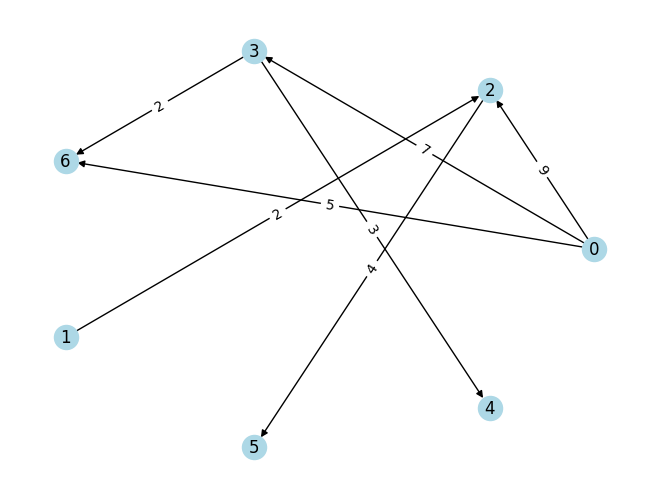

In [8]:
pos_dag = circular_layout(dag)
nx.draw(dag, pos_dag, with_labels=True, node_size=300, node_color='lightblue')
edge_labels_dag = dict([((u,v),d['weight']) for u,v,d in dag.edges(data=True)])
_ = nx.draw_networkx_edge_labels(dag, pos_dag, edge_labels=edge_labels_dag)

For acyclic graphs, we do not need a priority queue, but can instead use a topological order as a suitable relaxation order of the vertices.

In [9]:
from networkx.algorithms.dag import topological_sort

class AcyclicSSSP:
    def __init__(self, graph, start_node, drawing_pos):
        self.parent = [None] * len(graph)
        self.distance = [float('inf')] * len(graph)
        
        processed_nodes = [] # only for drawing

        self.distance[start_node] = 0
        top_order = list(topological_sort(graph))
        print("Use topological order:", top_order, "\n")
        
        start_pos = top_order.index(start_node)
        for node in top_order[start_pos:]:
            self.relax(graph, node)
            processed_nodes.append(node)
            self.dump(graph, processed_nodes, drawing_pos)

    def relax(self, graph, v):
        print("After relaxing vertex %i:" % v)
        for w in graph.successors(v):
            edge_weight = graph.get_edge_data(v,w)["weight"]
            if self.distance[v] + edge_weight < self.distance[w]:
                self.parent[w] = v
                self.distance[w] = self.distance[v] + edge_weight

    def path_to(self, node):
        if self.distance[node] == float('inf'):
            return None
        elif self.parent[node] == None:
            return [node]
        else:
            path = self.path_to(self.parent[node])
            path.append(node)
            return path
            
    def dump(self, graph, processed_nodes, pos):
        print("distances:", self.distance)
        print("parents:  ", self.parent)
        
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        
        reached_nodes = set(x for x in range(len(graph))
                            if self.distance[x] != float('inf') and x not in processed_nodes)
        best_edges = [(self.parent[i],i) for i in reached_nodes
                      if i not in processed_nodes and self.parent[i] is not None]
        finished_edges = [(self.parent[i],i) for i in processed_nodes
                          if self.parent[i] is not None]
        
        nx.draw_networkx_nodes(graph, pos, nodelist=processed_nodes, node_color='r')
        nx.draw_networkx_edges(graph, pos, edgelist=finished_edges, edge_color='r')
        nx.draw_networkx_nodes(graph, pos, nodelist=reached_nodes, node_color='b')
        nx.draw_networkx_edges(graph, pos, edgelist=best_edges, edge_color='b')
        plt.show()

Use topological order: [0, 1, 3, 2, 4, 6, 5] 

After relaxing vertex 1:
distances: [inf, 0, 2, inf, inf, inf, inf]
parents:   [None, None, 1, None, None, None, None]


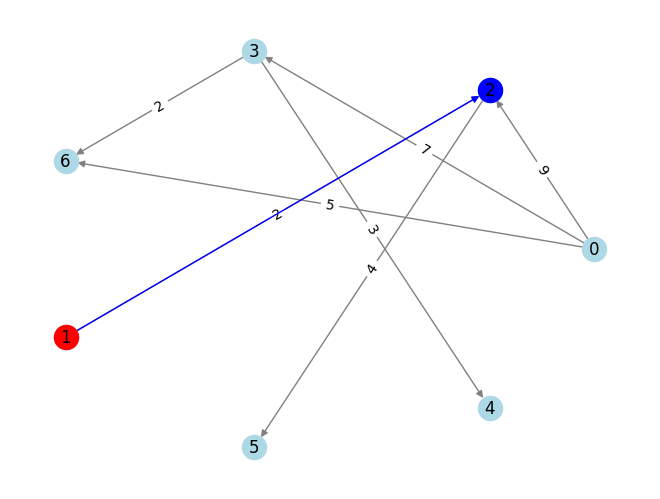

After relaxing vertex 3:
distances: [inf, 0, 2, inf, inf, inf, inf]
parents:   [None, None, 1, None, None, None, None]


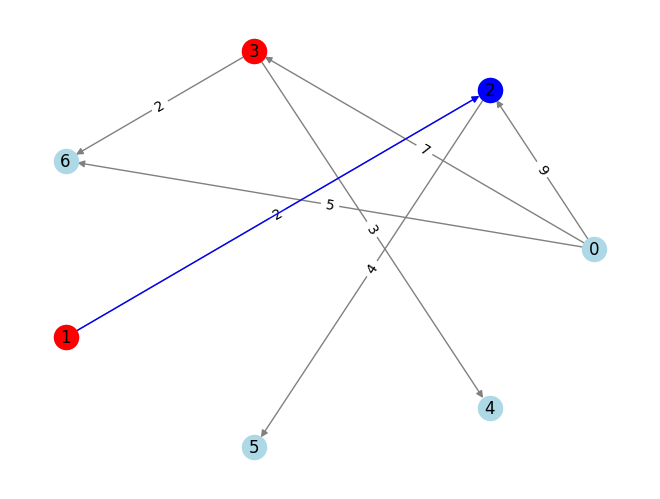

After relaxing vertex 2:
distances: [inf, 0, 2, inf, inf, 6, inf]
parents:   [None, None, 1, None, None, 2, None]


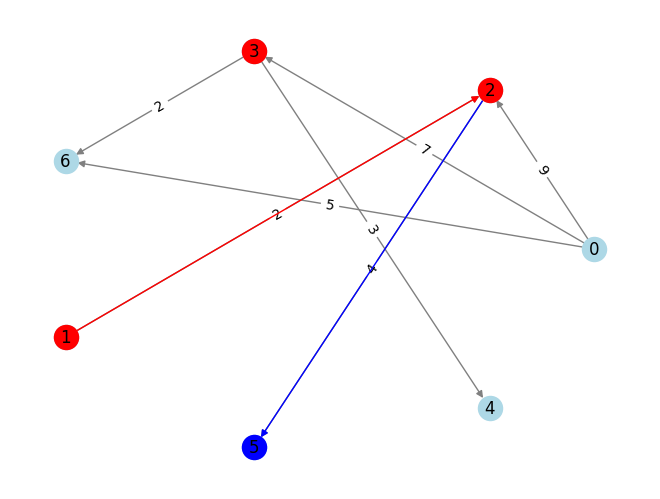

After relaxing vertex 4:
distances: [inf, 0, 2, inf, inf, 6, inf]
parents:   [None, None, 1, None, None, 2, None]


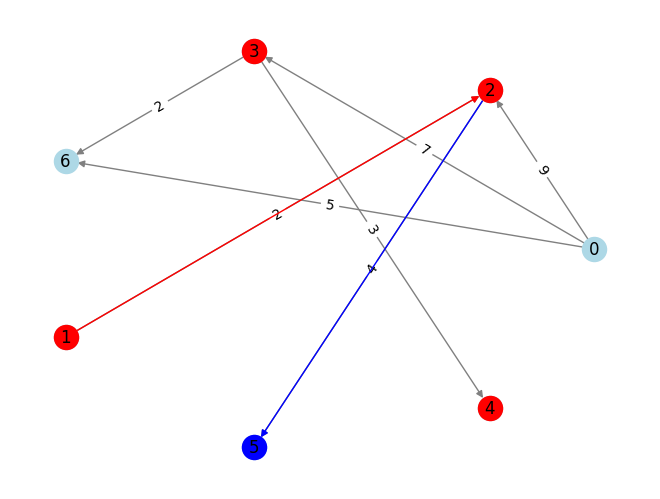

After relaxing vertex 6:
distances: [inf, 0, 2, inf, inf, 6, inf]
parents:   [None, None, 1, None, None, 2, None]


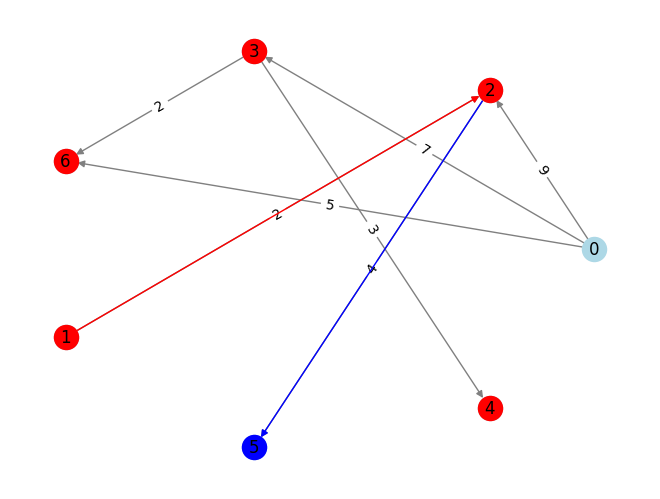

After relaxing vertex 5:
distances: [inf, 0, 2, inf, inf, 6, inf]
parents:   [None, None, 1, None, None, 2, None]


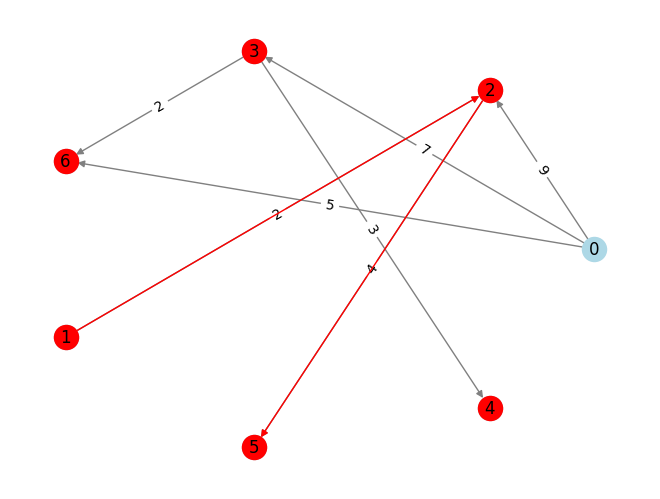

In [10]:
assp = AcyclicSSSP(dag, 1, pos_dag)

In [11]:
print(assp.path_to(5))

[1, 2, 5]
